In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, constants, optimize
%matplotlib inline
np.set_printoptions(precision=3)

import math
import migen
from migen import *

In [27]:
20*np.log10(4e-6)

-107.95880017344075

In [459]:
from migen import *

# CIC interpolation filter implementation
#
# * Designed with an eye on efficient use of resources, especially on ice40
# * multi-channel time-domain-multuplexing, pipelined
# * Using a wide BRAM for channel stage data storage
# * one output sample per clock cycle
#    (minimum output sample period per channel: number of channels)

# TODO
# [x] proper reset sequencing
# [x] check ice40 ebr mapping/mask
# [x] resource usage (clock domain (spi 2x16ch or word 3x11ch))
# [ ] Fastino integration
# [x] per channel interpolation rates
# [x] bypass for rate change and fast bursting
# ([ ] pipe draining: not possible/not required)
# ([ ] non-power-of-two number of channels: not necessary)
# ([ ] rate change/reset sequencing with output integrator
#     forced update: not necessary)
# ([ ] possibly n-by-m channels (iter-by-parallel) and a single BRAM:
#     not necessary)


class CIC(Module):
    def __init__(self, width=16, rate_width=16, order=3, channels=4):
        """
        width: input and output data width in bits including sign bit
        rate_width: rate ratio register width
        order: polynomial order (3 for cubic interpolation),
            CIC terminology order is `order + 1`
        channels: number of channels, must be power of two (currently,
            for easy wrapping)
        """
        # Current input sample for the given channel
        self.x = Signal((width, True), reset_less=True)
        # Input sample valid
        self.stb = Signal()
        # Clear combs and integrators to establish new rate for current channel.
        # This settles and bypasses the filter for `order` input samples
        # using the previous input sample. In bypass while settling
        # the gain is exactly 1.
        # This module needs a reset on all channels after a clock domain reset.
        self.reset = Signal()
        # Rate ratio is `r_output/r_input = rate + 1`
        # Only change `rate` when applying `reset` as well.
        self.rate = Signal(rate_width)
        # Output right shift to compensate filter gain
        # The overall filter gain is `(rate + 1) << order`
        # gain_shift should be `ceil(order * log2(rate + 1))`
        # Thus to ensure overall gain of 1 choose rates that are powers
        # of two.
        self.shift = Signal(max=order*rate_width + 1)

        # current channel
        self.xi = Signal(max=channels)
        # input sample acknowledged
        self.ack = Signal()

        # output sample for given output channel
        self.y = Signal((width, True), reset_less=True)
        # output channel
        self.yi = Signal(max=channels)

        ###

        # channel counter
        channel = Signal(max=channels)
        self.sync += [
            channel.eq(channel + 1),
            If(channel == channels - 1,
                channel.eq(0),
            ),
        ]
        self.comb += [
            self.xi.eq(channel),
            # pipeline latency, # TODO: modulo
            self.yi.eq(channel - 2*order - 1),
        ]

        # Memory and ports to work on. This is a pipelined CIC.
        layout = [
            # output sample counter per input sample
            ("i_rate", rate_width),
            # bypass input sample counter
            ("i_bypass", log2_int(order, need_pow2=False)),
            # input memory to ensure constancy over one output sample
            # and to support bypass
            ("x", (width, True)),
        ]
        # See Hogenauer 1981 for bitgrowth
        # Comb stages
        for n in range(order):
            layout.append(
                ("c{}".format(n), (width + n, True)))
        # Integrator stages
        for n in range(order):
            layout.append(
                ("i{}".format(n),
                (width + order + (rate_width - 1)*(n + 1), True)))
        read = Record(layout)
        write = Record(layout, reset_less=True)
        we = Signal(len(layout), reset_less=True)

        mem = Memory(len(read), channels)
        mem_r = mem.get_port()
        mem_w = mem.get_port(write_capable=True, we_granularity=1)
        self.specials += mem, mem_r, mem_w
        self.comb += [
            read.raw_bits().eq(mem_r.dat_r),
            mem_w.dat_w.eq(write.raw_bits()),
            mem_r.adr.eq(mem_w.adr + 2),  # TODO: modulo if not power of two
            mem_w.adr.eq(channel),
            mem_w.we.eq(Cat(
                Replicate(we[i], len(sig))
                for i, (sig, _) in enumerate(write.iter_flat()))),
        ]

        # state flags
        do_bypass = Signal()
        rate_done = Signal()
        self.comb += [
            rate_done.eq(read.i_rate == 0),
            do_bypass.eq(read.i_bypass != 0),
            self.ack.eq(rate_done & ~(do_bypass | self.reset)),
        ]

        # shift registers to ripple along the comb and integrator stages
        shift_sr = [Signal(max=order*rate_width + 1, reset_less=True)
            for _ in range(2*order)]
        bypass_sr = Signal(2*order, reset_less=True)
        x_sr = [Signal((width, True), reset_less=True) for _ in range(2*order)]
        self.sync += [
            Cat(shift_sr).eq(Cat(self.shift, shift_sr)),
            bypass_sr.eq(Cat(do_bypass | self.reset, bypass_sr)),
            Cat(x_sr).eq(Cat(read.x, x_sr)),
        ]

        self.sync += [
            # rate counter updates
            write.i_rate.eq(read.i_rate - 1),
            If(rate_done | self.reset,
                write.i_rate.eq(self.rate),
            ),
            we[0].eq(1),

            # bypass counter updates
            write.i_bypass.eq(read.i_bypass - 1),
            If(self.reset,
                write.i_bypass.eq(order),
            ),
            we[1].eq(self.reset | (do_bypass & rate_done)),

            # x memory updates
            write.x.eq(self.x),
            we[2].eq(self.stb & self.ack),

            # write-enable ripples through combs
            we[3:3 + order].eq(Cat(rate_done | self.reset, we[3:])),
            # integrators always write
            we[3 + order:].eq(Replicate(1, order)),
        ]

        # comb+integrator memory reset
        rst = Signal(2*order)
        rst_sr = Signal(2*order - 1, reset_less=True)
        # ripple through comb and integrator stages
        self.comb += [
            rst.eq(Cat(self.reset, rst_sr)),
        ]
        self.sync += [
            rst_sr.eq(rst),
        ]

        # Data path
        # For the integrators for a given channel, read is 2 cycles ahead of
        # write. The cycles are:
        #   0: read addr; 1: integ_r and delta, 2; integ_w write-back
        #   and next delta
        # This fixes the address offset also for the comb stages.
        # For the combs there would usually only be one cycle:
        #   0: read addr; 1: comb_r, old z, and comb_w write-back; 2: new z
        # Thus add one delay register at the write port to match the integrator
        # read-write pointer spacing:
        #   0: read addr; 1: comb_r, old z, and z1 store, 2: new z
        #   and comb_w write-back

        z = read.x
        # comb stages
        for n in range(order):
            cr = getattr(read, "c{}".format(n))
            cw = getattr(write, "c{}".format(n))
            z1 = Signal((len(cw) + 1, True), reset_less=True)
            self.sync += [
                cw.eq(z),
                z1.eq(z - cr),
                If(rst[n],
                    cw.eq(0),
                ),
            ]
            z = z1
        # integrator stages
        for n in range(order):
            ir = getattr(read, "i{}".format(n))
            iw = getattr(write, "i{}".format(n))
            self.sync += [
                iw.eq(ir + z),
                If(rst[order + n],
                    iw.eq(0),
                ),
            ]
            z = iw
        # output stage
        self.sync += [
            self.y.eq(z >> shift_sr[-1]),
            If(bypass_sr[-1],
               self.y.eq(x_sr[-1]),
            )
        ]

In [460]:
(16+17+18 + 34+49+64 + 16 + 16 + 2)/16

14.5

In [461]:
print(str(fhdl.verilog.convert(CIC(rate_width=16, order=3, width=16)))[:5000])

/* Machine-generated using Migen */
module top(
	input sys_clk,
	input sys_rst
);

reg signed [15:0] cic_x = 16'sd0;
reg cic_stb = 1'd0;
reg cic_reset = 1'd0;
reg [15:0] cic_rate = 16'd0;
reg [5:0] cic_shift = 6'd0;
wire [1:0] cic_xi;
wire cic_ack;
reg signed [15:0] cic_y = 16'sd0;
wire [1:0] cic_yi;
reg [1:0] cic_channel = 2'd0;
wire [15:0] cic_read_i_rate;
wire [1:0] cic_read_i_bypass;
wire signed [15:0] cic_read_x;
wire signed [15:0] cic_read_c0;
wire signed [16:0] cic_read_c1;
wire signed [17:0] cic_read_c2;
wire signed [33:0] cic_read_i0;
wire signed [48:0] cic_read_i1;
wire signed [63:0] cic_read_i2;
reg [15:0] cic_write_i_rate = 16'd0;
reg [1:0] cic_write_i_bypass = 2'd0;
reg signed [15:0] cic_write_x = 16'sd0;
reg signed [15:0] cic_write_c0 = 16'sd0;
reg signed [16:0] cic_write_c1 = 17'sd0;
reg signed [17:0] cic_write_c2 = 18'sd0;
reg signed [33:0] cic_write_i0 = 34'sd0;
reg signed [48:0] cic_write_i1 = 49'sd0;
reg signed [63:0] cic_write_i2 = 64'sd0;
reg [8:0] cic_we = 9'd0;
w

9 6


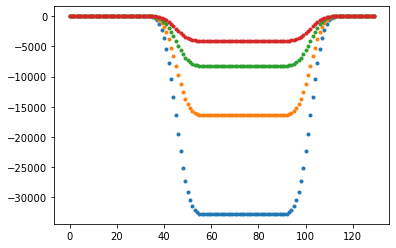

In [462]:
def feed(dut, x, r, g):
    yield dut.rate.eq(r)
    yield dut.shift.eq(g)
    yield dut.reset.eq(1)
    yield dut.stb.eq(1)
    # synchronize
    while (yield dut.xi) != len(x) - 1:
        yield
    for _ in range(len(x)):
        yield
    yield dut.reset.eq(0)
    while x[-1]:
        i = ((yield dut.xi) + 1) % len(x)
        yield dut.x.eq(x[i][0] >> i)
        if (yield dut.ack):
            x[i].pop(0)
        yield
    yield dut.x.eq(0)
    yield dut.reset.eq(1)
    for _ in range(len(x)):
        yield
    yield dut.reset.eq(0)
    for _ in range(len(x)*(r + 1)*3*order):
        yield

def record(dut, y):
    yield "passive"
    # synchronize
    while (yield dut.yi) != 0:
        yield
    while True:
        yj = (yield dut.yi)
        yi = (yield dut.y)
        y[yj].append(yi)
        yield

ch = 4
rate = 8
order = 3
width = 16
g = math.ceil(order*math.log2(rate))
dut = CIC(width=width, channels=ch, rate_width=16, order=order)
print(g, len(dut.shift))

x = [[-1<<15] * 4 for i in range(ch)]
y = [[] for i in range(ch)]
migen.sim.run_simulation(dut, [feed(dut, x, rate - 1, g), record(dut, y)], vcd_name="cic.vcd")
for yi in y:
    del yi[min(len(yi) for yi in y):]
plt.plot(np.array(y).T, ".");

In [444]:
# possible rates near power of two
# shift, rate, total gain
[(i, int(2**(i/3.)), int(2**(i/3.))**3/2**i) for i in range(16*3 + 1)]

[(0, 1, 1.0),
 (1, 1, 0.5),
 (2, 1, 0.25),
 (3, 2, 1.0),
 (4, 2, 0.5),
 (5, 3, 0.84375),
 (6, 4, 1.0),
 (7, 5, 0.9765625),
 (8, 6, 0.84375),
 (9, 8, 1.0),
 (10, 10, 0.9765625),
 (11, 12, 0.84375),
 (12, 16, 1.0),
 (13, 20, 0.9765625),
 (14, 25, 0.95367431640625),
 (15, 32, 1.0),
 (16, 40, 0.9765625),
 (17, 50, 0.95367431640625),
 (18, 64, 1.0),
 (19, 80, 0.9765625),
 (20, 101, 0.9825716018676758),
 (21, 128, 1.0),
 (22, 161, 0.9949877262115479),
 (23, 203, 0.9972366094589233),
 (24, 256, 1.0),
 (25, 322, 0.9949877262115479),
 (26, 406, 0.9972366094589233),
 (27, 512, 1.0),
 (28, 645, 0.9996299631893635),
 (29, 812, 0.9972366094589233),
 (30, 1024, 1.0),
 (31, 1290, 0.9996299631893635),
 (32, 1625, 0.9990799298975617),
 (33, 2048, 1.0),
 (34, 2580, 0.9996299631893635),
 (35, 3250, 0.9990799298975617),
 (36, 4096, 1.0),
 (37, 5160, 0.9996299631893635),
 (38, 6501, 0.9995411146555853),
 (39, 8192, 1.0),
 (40, 10321, 0.9999205814538072),
 (41, 13003, 0.9997717602468583),
 (42, 16384, 1.0),